# Inference

## COCO Score

In [5]:
!/opt/conda/bin/python /workspace/src/mmdetection/tools/test.py \
    work_dirs/rtmdet-l_ins/rtmdet-l_ins.py work_dirs/rtmdet-l_ins/epoch_50.pth  \
    --work-dir work_dirs/rtmdet-l_ins/inference/

10/01 23:49:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
    CUDA available: True
    numpy_random_seed: 1294143412
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.1, V11.1.105
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.9.0
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=

## Sample Visualize

In [51]:
import os

import tifffile
import numpy as np
import matplotlib.pyplot as plt

from mmdet.apis import init_detector, inference_detector

model = init_detector(
    config="work_dirs/rtmdet-l_ins/rtmdet-l_ins.py",
    checkpoint="work_dirs/rtmdet-l_ins/epoch_50.pth",
    device="cuda:0"
)

THRESHOLD = 0.75
PATH = '/workspace/sample/train_scale1_h640_w640_oh0.0_ow0.0_min1_segs/20APR04014122-S2AS_R1C1-015150647030_01_P001_channel-last_15360_9600_16000_10240.tif'
img = tifffile.imread(PATH)
img = img.astype(np.float32).transpose(1, 2, 0)

results = inference_detector(model=model, imgs=img)

Loads checkpoint by local backend from path: work_dirs/rtmdet-l_ins/epoch_50.pth


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


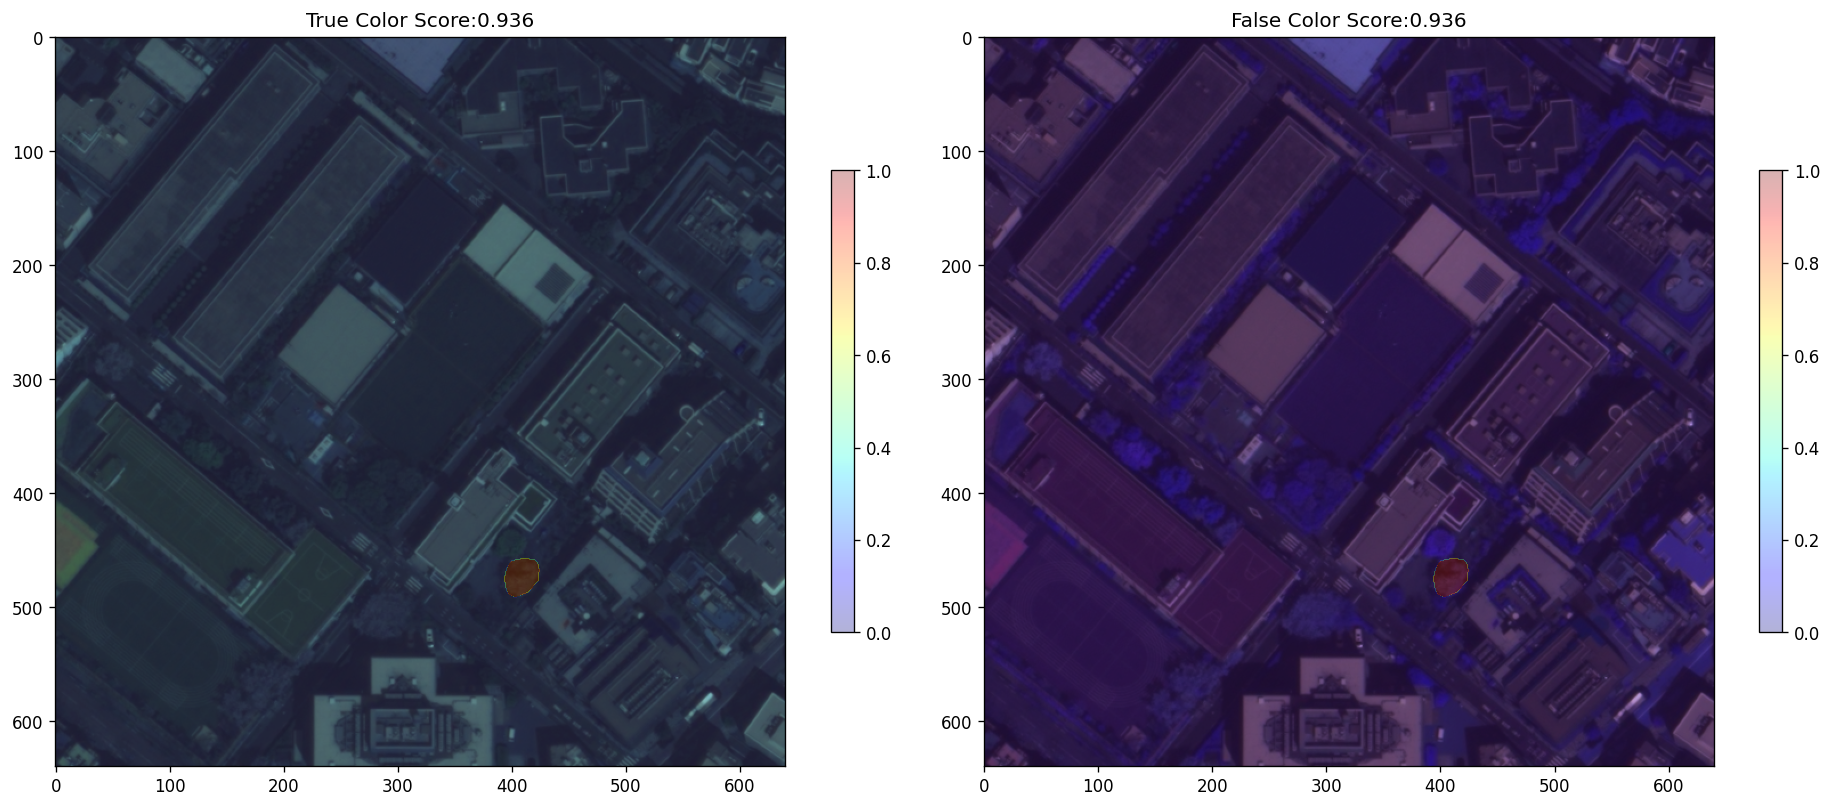

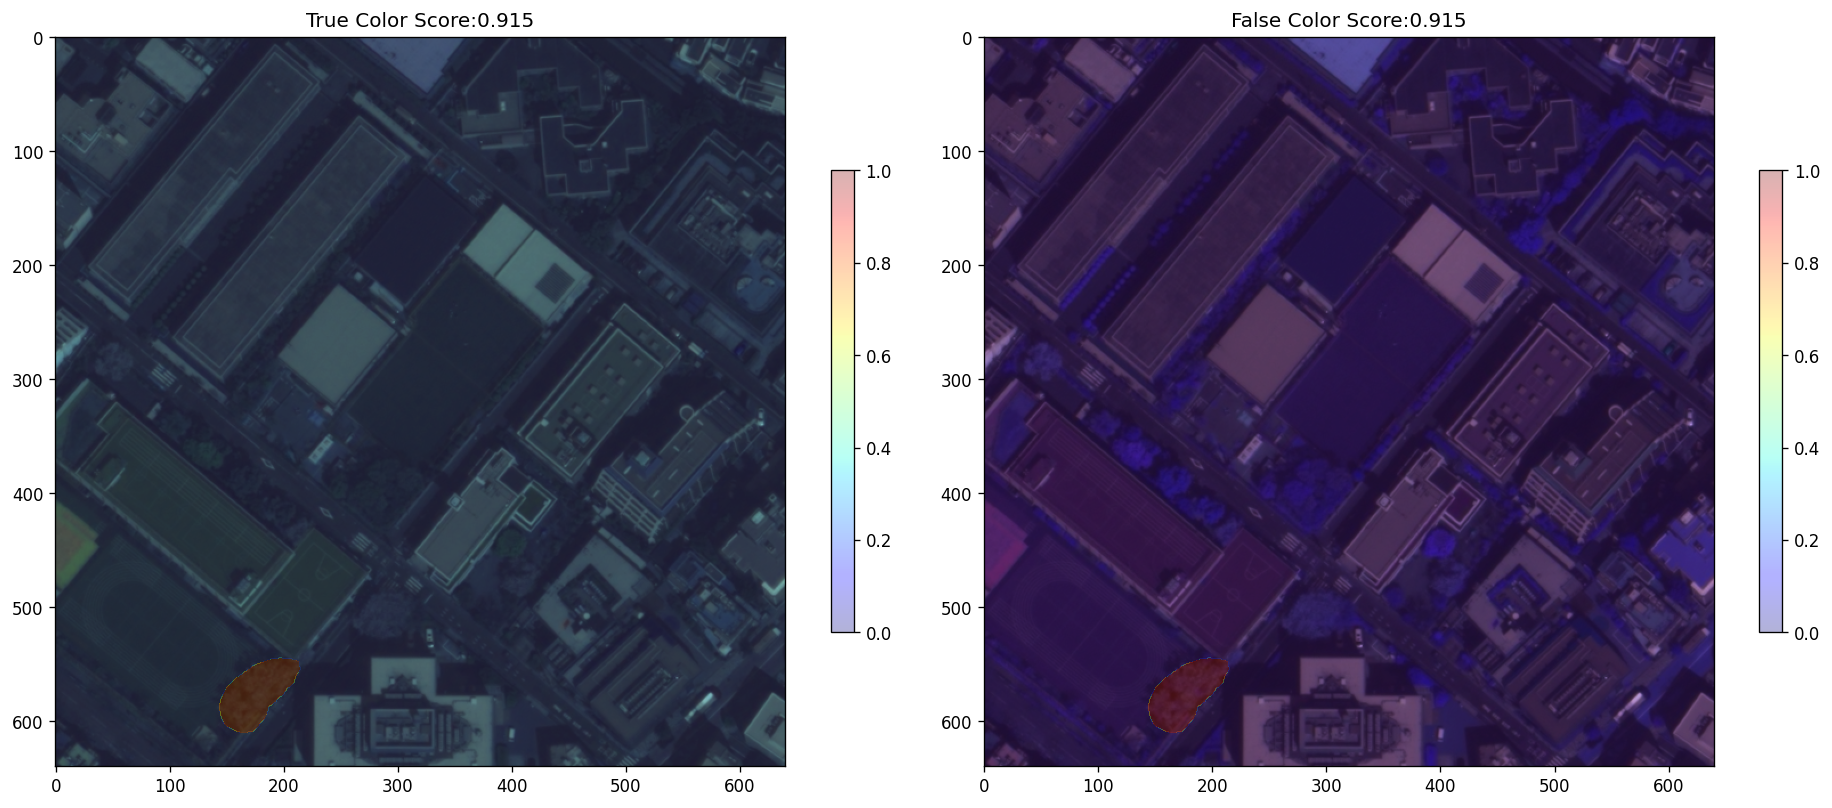

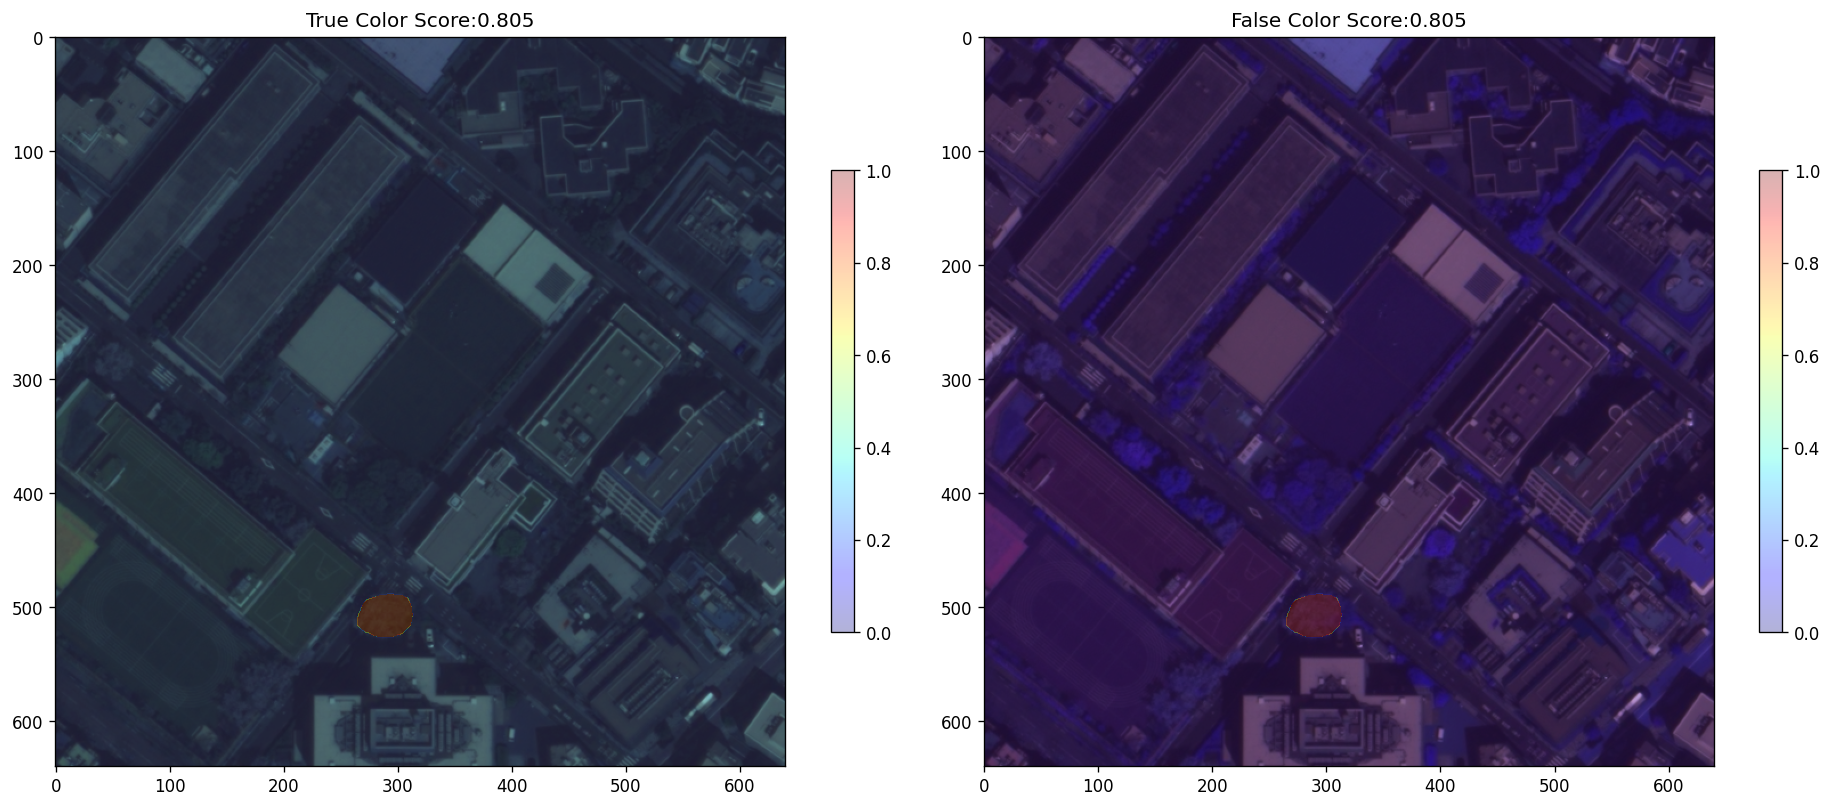

tensor(0.0143, device='cuda:0') torch.Size([640, 640]) tensor(0, device='cuda:0') torch.Size([4])


In [56]:
COUNT = 0

for res in results.pred_instances:
    for score, mask, label, bbox in zip(res.scores, res.masks, res.labels, res.bboxes):

        if score > THRESHOLD:
            COUNT += 1
            
            sc = score.cpu().numpy()
            
            mask = mask.cpu().numpy()
            img = img / img.max()
            
            plt.figure(figsize=(16, 8), dpi=120)
            plt.subplot(1, 2, 1)
            plt.title(f'True Color Score:{sc:.3f}')
            plt.imshow(img[:, :, :3])
            
            plt.imshow(mask, alpha=0.3, cmap='jet')
            plt.colorbar(shrink=0.5)
            
            plt.subplot(1, 2, 2)
            plt.title(f'False Color Score:{sc:.3f}')
            plt.imshow(img[:, :, 1:])
            
            plt.imshow(mask, alpha=0.3, cmap='jet')
            plt.colorbar(shrink=0.5,)
            
            plt.tight_layout()
            
            os.makedirs('output/003/', exist_ok=True)
            plt.savefig(f'output/003/sample_inference_{COUNT}.jpg')
            
            plt.show();
            plt.clf()
            plt.close()


print(score, mask.shape, label, bbox.shape)     

In [67]:
from glob import glob
from tqdm import tqdm
import cv2

PATHS_TIF = glob("/workspace/sample/train_scale1_h640_w640_oh0.0_ow0.0_min1_segs/*.tif")
print(f'Num: {len(PATHS_TIF)}')

for PATH in tqdm(PATHS_TIF):
    
    img = tifffile.imread(PATH)
    img = img.astype(np.float32).transpose(1, 2, 0)
    
    if img.shape[:2] != (640, 640):
        continue

    results = inference_detector(model=model, imgs=img)
    
    pred = np.zeros((img.shape[:2]), dtype=np.float32)
    
    for res in results.pred_instances:
        for score, mask, label, bbox in zip(res.scores, res.masks, res.labels, res.bboxes):
            if score > THRESHOLD:
                mask = mask.cpu().numpy()
                pred += mask
    
    PATH_PRED = PATH.replace('.tif', '.png')
    
    pred = np.clip(pred * 255, a_max=255, a_min=0).astype(np.uint8)
    cv2.imwrite(PATH_PRED, pred)

PATH_PRED

  0%|          | 2/1352 [00:00<01:14, 18.17it/s]

Num: 1352


100%|██████████| 1352/1352 [01:10<00:00, 19.20it/s]


'/workspace/sample/train_scale1_h640_w640_oh0.0_ow0.0_min1_segs/20APR04014122-S2AS_R1C1-015150647030_01_P001_channel-last_1280_15744_1920_16384.png'